In [58]:
#Jalar bibliotecas que serán de utilidad para la tarea: 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import sqldf
import scipy.stats
from scipy.special import gamma
from scipy.stats import beta
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [59]:
ruta = "./data/"
bd = "base_ini_externa.txt"
bd_ini_externa = pd.read_csv(ruta+bd,sep=" ")
bd_ini_externa.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4
0,78213,260.869565,25.854639,56.0,-230.0
1,76457,40.579710,2.872738,62.0,-230.0
2,40666,NaN,NaN,119.0,-230.0
3,8329,349.275362,34.616490,94.0,-230.0
4,68389,276.811594,27.434645,125.0,-230.0


In [60]:
bd="base_ini_interna.csv"
bd_ini_interna = pd.read_csv(ruta+bd)
bd_ini_interna.head()

,_id_,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
0,78213,2020-03-25,0.000000,b'0',11.0,58.0,2.0,9.0,156.0
1,76457,2020-02-13,0.000000,b'1',28.0,45.0,1.0,4.0,173.0
2,40666,2018-01-24,0.000000,b'1',25.0,45.0,1.0,9.0,170.0
3,8329,2016-10-07,0.000000,b'1',14.0,59.0,3.0,3.0,159.0
4,68389,2019-07-30,2026.342452,b'1',1.0,67.0,2.0,9.0,146.0


In [61]:
bd="base_ini_parte1.csv"
bd_ini_parte1 = pd.read_csv(ruta+bd)
bd_ini_parte1.head()

,_id_,_id2_,comp_mixto1
0,78213,1798899,0.33522
1,76457,1758511,0.33334
2,40666,935318,0.29186
3,8329,191567,0.29112
4,68389,1572947,0.27318


In [62]:
bd = "base_comportamiento_2.txt"
bd_comportamiento_2 = pd.read_csv(ruta+bd,sep=" ",low_memory=False)
bd_comportamiento_2.head()

,num_caso,mes_informacion,Tiempo_aparicion
0,1,2016-04-01 00:00:00,0.0
1,1,2016-05-01 00:00:00,1.0
2,1,2016-06-01 00:00:00,2.0
3,1,2016-07-01 00:00:00,3.0
4,1,2016-08-01 00:00:00,4.0


In [63]:
query ="""
       select num_caso as _id_,count(Tiempo_aparicion) as cantidad_tramites 
       from bd_comportamiento_2 where Tiempo_aparicion=0
       group by num_caso
       """
no_tramites=sqldf.run(query)

In [64]:
query ="""
       select num_caso as _id_,max(mes_informacion) as ultima_fecha 
       from bd_comportamiento_2
       group by num_caso
       """
ultimafecha=sqldf.run(query)

In [65]:
bdaux=bd_comportamiento_2.loc[bd_comportamiento_2['num_caso'].isin([8768 ,25022,38975 ,39026,53960 ,54384,95055])]
query=""" select num_caso,min(Tiempo_aparicion)
          from bdaux
          group by num_caso"""
bdauxiliar=sqldf.run(query)
sintesis_c2=no_tramites.merge(ultimafecha,how="right",on="_id_")
sintesis_c2=sintesis_c2.fillna(1)

In [66]:
bd = "base_comportamiento_3.csv"
bd_comportamiento_3 = pd.read_csv(ruta+bd,low_memory=False)
bd_comportamiento_3.head(10)

,num_caso,mes_informacion,comportamiento_j
0,1,2016-04-01 00:00:00,0.0
1,1,2016-05-01 00:00:00,0.0
2,1,2016-06-01 00:00:00,0.0
3,1,2016-07-01 00:00:00,0.0
4,1,2016-08-01 00:00:00,0.0
5,1,2016-09-01 00:00:00,0.0
6,1,2016-10-01 00:00:00,0.0
7,1,2016-11-01 00:00:00,0.0
8,1,2016-12-01 00:00:00,0.0
9,1,2017-01-01 00:00:00,1.0


In [67]:
query="""select num_caso as _id_,min(mes_informacion),max(mes_informacion)
         from bd_comportamiento_3
         group by num_caso"""
olvidada =sqldf.run(query)

In [68]:
query1="""select 
         num_caso,
         mes_informacion,
         comportamiento_j
         from bd_comportamiento_3
         order by num_caso,mes_informacion
         """
baseji=sqldf.run(query1).groupby("num_caso").tail(12)
baseji.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

In [69]:
query="""select 
         num_caso as _id_,         
         avg(comportamiento_j),
         max(comportamiento_j)
         from baseji
         group by num_caso
         """
sintesis_c3=sqldf.run(query)

In [70]:
query="""
     select num_caso,count(comportamiento_j),comportamiento_j
     from baseji
     group by num_caso,comportamiento_j
"""
deuda=sqldf.run(query)

In [71]:
constructo=sintesis_c3[["_id_"]]
premade="_meses_deuda"
for i in range(0,int(deuda[["comportamiento_j"]].max().iloc[0])+1):
    especifico=str(i)
    constructo.loc[:,especifico+premade]=0
constructo.head()    

C:\Users\andre\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\andre\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,_id_,0_meses_deuda,1_meses_deuda,2_meses_deuda,3_meses_deuda,4_meses_deuda,5_meses_deuda,6_meses_deuda,7_meses_deuda,8_meses_deuda,9_meses_deuda,10_meses_deuda,11_meses_deuda,12_meses_deuda,13_meses_deuda,14_meses_deuda,15_meses_deuda,16_meses_deuda,17_meses_deuda,18_meses_deuda
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
premade="_meses_deuda"
paso_anterior=0
for i in range(0,len(deuda)):
    paso_actual=deuda.iloc[i,0]
    if paso_actual==paso_anterior:
        especifico=str(int(deuda.iloc[i,2]))
        constructo.loc[vector_auxiliar,especifico+premade]=deuda.iloc[i,1]
    else:
        vector_auxiliar=(constructo["_id_"]==paso_actual)
        especifico=str(int(deuda.iloc[i,2]))
        constructo.loc[vector_auxiliar,especifico+premade]=deuda.iloc[i,1]
        paso_anterior=paso_actual  
        

In [73]:
constructo.columns=["_id_","cero_meses","uno_meses","dos_meses","tres_meses","cuatro_meses","cinco_meses","seis_meses","siete_meses","ocho_meses","nueve_meses","diez_meses","once_meses","doce_meses","trece_meses","catorce_meses","quince_meses","dseis_meses","dsiete_meses","docho_meses"]

In [74]:
query="""
        select _id_,
        cero_meses,
        uno_meses+dos_meses+tres_meses+cuatro_meses+cinco_meses+seis_meses+siete_meses+ocho_meses+nueve_meses+diez_meses+once_meses+doce_meses+trece_meses+catorce_meses+quince_meses+dseis_meses+dsiete_meses+docho_meses as uno_o_mas
        from constructo
"""
cons_aux=sqldf.run(query)

In [75]:
sintesis_c3_aux=sintesis_c3.merge(cons_aux,how="inner",on="_id_")

In [76]:
bd="base_inversion.txt"
bd_base_inversion= pd.read_csv(ruta+bd,sep=" ")
bd_base_inversion.head()

,_id2_,inversion
0,1758511,0.041039
1,1572947,77.422135
2,1051836,90.539953
3,1223255,90.205018
4,1894602,1.071354


In [77]:
bd="base_ini_parte1.csv"
bd_ini_parte1= pd.read_csv(ruta+bd)
bd_ini_parte1.head()

,_id_,_id2_,comp_mixto1
0,78213,1798899,0.33522
1,76457,1758511,0.33334
2,40666,935318,0.29186
3,8329,191567,0.29112
4,68389,1572947,0.27318


In [78]:
base_general=bd_ini_externa.merge(bd_ini_interna,how='inner',on='_id_')
base_general=base_general.sort_values('_id_')
base_general.head(10)

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
26635,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,3.0,3.0,171.0
20520,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,1.0,11.0,173.0
9400,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,2.0,6.0,159.0
15618,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,2.0,9.0,156.0
10561,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,2.0,6.0,156.0
6760,14,747.826087,74.116633,117.0,-230.0,2016-02-11,0.000000,b'1',19.0,68.0,4.0,3.0,164.0
38571,18,307.246377,30.451020,122.0,-230.0,2016-08-16,0.000000,b'1',14.0,50.0,2.0,5.0,159.0
10942,21,202.898551,18.672795,126.0,-230.0,2016-11-23,0.000000,b'0',14.0,75.0,2.0,9.0,159.0
42700,22,579.710145,57.454754,36.0,-230.0,2016-11-16,1317.122594,b'1',11.0,53.0,2.0,9.0,156.0
8115,24,37.681159,3.734559,131.0,-230.0,2016-06-13,0.000000,b'1',19.0,52.0,3.0,3.0,164.0


In [245]:
#Juntamos los sintesis del comportamiento2 y 3, porque tienen la misma cantidad de _id_'s
base_auxiliar=sintesis_c2.merge(sintesis_c3_aux,how='inner',on='_id_')
base_general_2=base_general.merge(base_auxiliar,how='left',on='_id_')
base_general_3=base_general_2.merge(bd_ini_parte1,how="inner",on="_id_")
base_general_4=base_general_3.merge(bd_base_inversion,how="left",on="_id2_")
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,categoria3,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,...,171.0,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,...,173.0,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,...,159.0,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,...,156.0,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,...,156.0,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568


In [246]:
base_general_4[['comp_interno1','cero_meses','inversion']] = base_general_4[['comp_interno1','cero_meses','inversion']].fillna(value=0)
base_general_4[['max(comportamiento_j)']] = base_general_4[['max(comportamiento_j)']].fillna(value=30)
base_criterios=base_general_4[['_id_','comp_interno1', 'max(comportamiento_j)','cero_meses','inversion']].sort_values(by = '_id_')


In [247]:
base_criterios.loc[base_criterios['cero_meses']>=11,'Calif_1']=2
base_criterios.loc[(base_criterios['cero_meses']>=9) & (base_criterios['cero_meses']<=10) ,'Calif_1']=1
base_criterios.loc[base_criterios['cero_meses']<9,'Calif_1']=0

In [248]:
base_criterios.loc[base_criterios['max(comportamiento_j)']<=4,'Calif_2']=2
base_criterios.loc[(base_criterios['max(comportamiento_j)']>4) & (base_criterios['max(comportamiento_j)']<=6) ,'Calif_2']=1
base_criterios.loc[base_criterios['max(comportamiento_j)']>6,'Calif_2']=0


In [249]:
base_criterios.loc[base_criterios['inversion']>500,'Calif_3']=2
base_criterios.loc[(base_criterios['inversion']>=150) & (base_criterios['inversion']<=500) ,'Calif_3']=1
base_criterios.loc[base_criterios['inversion']<150,'Calif_3']=0

In [250]:
base_criterios.loc[base_criterios['comp_interno1']>25000,'Calif_4']=2
base_criterios.loc[(base_criterios['comp_interno1']>=3000) & (base_criterios['comp_interno1']<=25000) ,'Calif_4']=1
base_criterios.loc[base_criterios['comp_interno1']<3000,'Calif_4']=0


In [251]:
base_criterios['suma']=base_criterios['Calif_1']+base_criterios['Calif_2']+base_criterios['Calif_3']+base_criterios['Calif_4']
base_criterios.loc[base_criterios['suma']>=4,'Resultado']=1
base_criterios.loc[base_criterios['suma']<4,'Resultado']=0
base_general_4['Respuesta']=base_criterios['Resultado']

In [252]:
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,1.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,0.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,1.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,1.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,1.0


In [254]:
ji=base_general_4["comp_interno2"]=="b'1'"
base_general_4.iloc[ji,7]=1.0
ja=base_general_4["comp_interno2"]=="b'0'"
base_general_4.iloc[ja,7]=0.0
base_general_4["comp_interno2"]=base_general_4["comp_interno2"].astype('float64')

In [255]:
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,1.0,26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,1.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,1.0,28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,0.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,1.0,14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,1.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,1.0,11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,1.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,1.0,11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,1.0


In [256]:
base_general_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id_                   50000 non-null  int64  
 1   comp_externo1          47831 non-null  float64
 2   comp_externo2          44410 non-null  float64
 3   comp_externo3          49994 non-null  float64
 4   comp_externo4          50000 non-null  float64
 5   fecha_inicio           50000 non-null  object 
 6   comp_interno1          50000 non-null  float64
 7   comp_interno2          50000 non-null  float64
 8   comp_interno3          50000 non-null  float64
 9   comp_interno4          50000 non-null  float64
 10  categoria1             50000 non-null  float64
 11  categoria2             50000 non-null  float64
 12  categoria3             50000 non-null  float64
 13  cantidad_tramites      49352 non-null  float64
 14  ultima_fecha           49352 non-null  object 
 15  av

In [257]:
base_general_4.to_csv("Base_tarea1.csv")

# MODELO LOGÍSTICO


In [90]:
from optbinning import OptimalBinning

In [192]:
base_general_4=pd.read_csv("C:\\Users\\andre\\Desktop\\Daniel .v\\Semestre 2022-1\\Seminario Estadística I\\Base_buena.csv")

In [194]:
base_general_4=base_general_4.iloc[:,1:]

In [195]:
base_general_4.head()

,_id_,_id2_,comp_mixto1,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3,inversion,mes_informacion,Tiempo_aparicion,mean_comportamiento_j,credito
0,2333,53659,0.32856,2016-01-04,6079.027356,b'1',30.0,50.0,2.0,9.0,175.0,0.000000,2021-05-01 00:00:00,52.0,0.076923,1
1,488,11224,0.38498,2016-01-04,911.854103,b'0',19.0,48.0,3.0,3.0,164.0,0.000000,2021-05-01 00:00:00,64.0,0.123077,1
2,1964,45172,0.34780,2016-01-04,0.000000,b'1',19.0,53.0,4.0,3.0,164.0,0.000000,2021-05-01 00:00:00,64.0,0.076923,1
3,1220,28060,0.28422,2016-01-04,2482.269504,b'0',9.0,70.0,3.0,9.0,154.0,0.000000,2021-05-01 00:00:00,58.0,0.030769,1
4,1226,28198,0.31500,2016-01-04,0.000000,b'1',3.0,75.0,3.0,9.0,148.0,0.311552,2018-10-01 00:00:00,33.0,0.029412,1


In [196]:
columnas=list(base_general_4.columns.values)
columnas.remove("_id_")
columnas.remove("_id2_")
print(columnas)

['comp_mixto1', 'fecha_inicio', 'comp_interno1', 'comp_interno2', 'comp_interno3', 'comp_interno4', 'categoria1', 'categoria2', 'categoria3', 'inversion', 'mes_informacion', 'Tiempo_aparicion', 'mean_comportamiento_j', 'credito']


In [197]:
train, test = train_test_split(base_general_4[columnas], test_size = 0.30, random_state = 100) 

In [198]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 48824 to 38408
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_mixto1            35000 non-null  float64
 1   fecha_inicio           35000 non-null  object 
 2   comp_interno1          35000 non-null  float64
 3   comp_interno2          35000 non-null  object 
 4   comp_interno3          35000 non-null  float64
 5   comp_interno4          35000 non-null  float64
 6   categoria1             35000 non-null  float64
 7   categoria2             35000 non-null  float64
 8   categoria3             35000 non-null  float64
 9   inversion              35000 non-null  float64
 10  mes_informacion        34556 non-null  object 
 11  Tiempo_aparicion       34556 non-null  float64
 12  mean_comportamiento_j  34556 non-null  float64
 13  credito                35000 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 

In [199]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 4253 to 25776
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_mixto1            15000 non-null  float64
 1   fecha_inicio           15000 non-null  object 
 2   comp_interno1          15000 non-null  float64
 3   comp_interno2          15000 non-null  object 
 4   comp_interno3          15000 non-null  float64
 5   comp_interno4          15000 non-null  float64
 6   categoria1             15000 non-null  float64
 7   categoria2             15000 non-null  float64
 8   categoria3             15000 non-null  float64
 9   inversion              15000 non-null  float64
 10  mes_informacion        14796 non-null  object 
 11  Tiempo_aparicion       14796 non-null  float64
 12  mean_comportamiento_j  14796 non-null  float64
 13  credito                15000 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 1

In [159]:
#y=train.Respuesta
y=train.credito

In [200]:
categoricas=[columnas.remove("comp_interno2"),columnas.remove("categoria1"),columnas.remove("categoria2"),columnas.remove("categoria3")]
categoricas=["comp_interno2","categoria1","categoria2","categoria3"]

categoricas

['comp_interno2', 'categoria1', 'categoria2', 'categoria3']

In [201]:
columnas

['comp_mixto1',
 'fecha_inicio',
 'comp_interno1',
 'comp_interno3',
 'comp_interno4',
 'inversion',
 'mes_informacion',
 'Tiempo_aparicion',
 'mean_comportamiento_j',
 'credito']

In [202]:
columnas.remove("credito")

#Ver qué pasa con las fechas
columnas.remove("fecha_inicio")
#columnas.remove("ultima_fecha")
columnas.remove("mes_informacion")

In [203]:
opts=[] 
denuevo=list(base_general_4.columns.values)
denuevo.remove("_id_")
denuevo.remove("_id2_")
denuevo.remove("credito")
#Por alta correlación se quitan los siguientes
#denuevo.remove("avg(comportamiento_j)")
#denuevo.remove("max(comportamiento_j)")
#denuevo.remove("uno_o_mas")
#denuevo.remove("comp_externo1")
denuevo.remove("fecha_inicio")
denuevo.remove("mes_informacion")
#denuevo.remove("inversion")
#denuevo.remove("comp_interno3")
for i in denuevo:
    if i in columnas:
        opts.append(OptimalBinning(name=i, dtype="numerical", solver="cp"))
    else:
        opts.append(OptimalBinning(name=i, dtype="categorical", solver="mip"))

In [204]:
for i in range(len(denuevo)):
    opts[i].fit(train[denuevo[i]],y)

In [205]:
premade="woe_"
for i in range(len(denuevo)):
    train[premade+denuevo[i]]=opts[i].transform(train[denuevo[i]], metric="woe")

In [206]:
train.head(10)


,comp_mixto1,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3,inversion,...,woe_comp_interno1,woe_comp_interno2,woe_comp_interno3,woe_comp_interno4,woe_categoria1,woe_categoria2,woe_categoria3,woe_inversion,woe_Tiempo_aparicion,woe_mean_comportamiento_j
48824,0.31200,2021-03-02,0.000000,b'0',1.0,44.0,1.0,9.0,146.0,0.000000,...,0.021887,-0.044105,-0.005979,-0.055921,-0.004036,0.050837,0.056787,0.014892,2.071414,0.903962
2704,0.23526,2016-05-05,11144.883485,b'1',15.0,75.0,1.0,9.0,160.0,0.000000,...,0.069967,0.018270,-0.005979,0.002431,-0.004036,0.050837,-0.096611,0.014892,-0.343347,-0.329033
25631,0.38000,2018-09-06,0.000000,b'0',24.0,47.0,1.0,10.0,169.0,0.000000,...,0.021887,-0.044105,-0.064967,0.003111,-0.004036,-0.187728,-0.080717,0.014892,-0.382185,-0.226451
7285,0.36800,2016-10-24,0.000000,b'1',25.0,42.0,1.0,9.0,170.0,0.000000,...,0.021887,0.018270,-0.064967,-0.093932,-0.004036,0.050837,-0.040321,0.014892,-0.382185,-0.402764
27346,0.33242,2018-11-12,0.000000,b'1',28.0,69.0,3.0,9.0,173.0,43.376254,...,0.021887,0.018270,-0.064967,0.117419,-0.019677,0.050837,-0.175232,-0.015887,-0.418500,-0.495017
40815,0.37666,2020-05-29,1519.756839,b'1',22.0,46.0,1.0,3.0,167.0,0.000000,...,-0.027578,0.018270,0.035799,-0.008896,-0.004036,-0.021268,0.092205,0.014892,-0.218628,-0.038206
22137,0.38000,2018-05-02,1013.171226,b'0',8.0,61.0,1.0,9.0,153.0,0.000000,...,-0.027578,-0.044105,-0.005979,0.003111,-0.004036,0.050837,-0.175232,0.014892,-0.553893,0.903962
25070,0.34350,2018-08-16,0.000000,b'1',1.0,45.0,1.0,9.0,146.0,195.430315,...,0.021887,0.018270,-0.005979,-0.008896,-0.004036,0.050837,0.056787,-0.015887,-0.382185,-0.189843
15687,0.26000,2017-08-28,0.000000,b'0',14.0,43.0,1.0,6.0,159.0,0.000000,...,0.021887,-0.044105,-0.005979,-0.055921,-0.004036,-0.131459,0.051077,0.014892,-0.496284,-0.226451
14780,0.38000,2017-07-26,0.000000,b'1',21.0,50.0,1.0,6.0,166.0,0.000000,...,0.021887,0.018270,0.035799,0.003111,-0.004036,-0.131459,-0.053842,0.014892,-0.382185,-0.495017


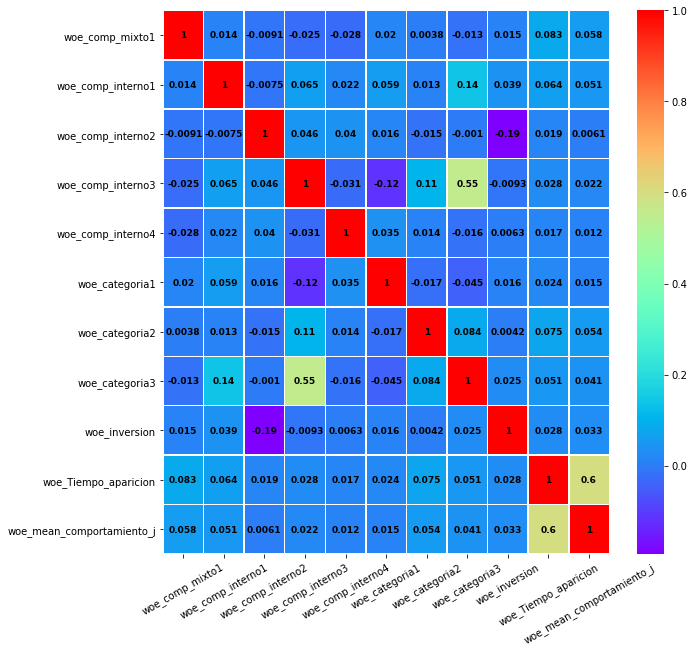

In [217]:
corr = train.iloc[:,14:].corr()
#corr = train.iloc[:,21:].corr()

xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [234]:
X_woe_train=train.iloc[:,14:]
y_train=train.iloc[:,13]
X_woe_train.head(10)

,woe_comp_mixto1,woe_comp_interno1,woe_comp_interno2,woe_comp_interno3,woe_comp_interno4,woe_categoria1,woe_categoria2,woe_categoria3,woe_inversion,woe_Tiempo_aparicion,woe_mean_comportamiento_j
48824,0.010044,0.021887,-0.044105,-0.005979,-0.055921,-0.004036,0.050837,0.056787,0.014892,2.071414,0.903962
2704,0.010044,0.069967,0.018270,-0.005979,0.002431,-0.004036,0.050837,-0.096611,0.014892,-0.343347,-0.329033
25631,-0.198613,0.021887,-0.044105,-0.064967,0.003111,-0.004036,-0.187728,-0.080717,0.014892,-0.382185,-0.226451
7285,-0.027990,0.021887,0.018270,-0.064967,-0.093932,-0.004036,0.050837,-0.040321,0.014892,-0.382185,-0.402764
27346,0.010044,0.021887,0.018270,-0.064967,0.117419,-0.019677,0.050837,-0.175232,-0.015887,-0.418500,-0.495017
40815,-0.027990,-0.027578,0.018270,0.035799,-0.008896,-0.004036,-0.021268,0.092205,0.014892,-0.218628,-0.038206
22137,-0.198613,-0.027578,-0.044105,-0.005979,0.003111,-0.004036,0.050837,-0.175232,0.014892,-0.553893,0.903962
25070,0.072940,0.021887,0.018270,-0.005979,-0.008896,-0.004036,0.050837,0.056787,-0.015887,-0.382185,-0.189843
15687,0.010044,0.021887,-0.044105,-0.005979,-0.055921,-0.004036,-0.131459,0.051077,0.014892,-0.496284,-0.226451
14780,-0.198613,0.021887,0.018270,0.035799,0.003111,-0.004036,-0.131459,-0.053842,0.014892,-0.382185,-0.495017


In [235]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_train,sm.add_constant(X_woe_train)).fit()

Optimization terminated successfully.
         Current function value: 0.223348
         Iterations 8


In [236]:
print(logitmodel.summary())

                           Logit Regression Results                           
Dep. Variable:                credito   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34988
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                 0.02571
Time:                        22:23:49   Log-Likelihood:                -7817.2
converged:                       True   LL-Null:                       -8023.4
Covariance Type:            nonrobust   LLR p-value:                 1.349e-81
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.8227      0.025    114.324      0.000       2.774       2.871
woe_comp_mixto1               0.2785      0.245      1.135      0.257      -0.203     

Según nuestras observaciones, se puede observar que las variables:
* woe_comp_externo2
* woe_comp_externo3   
* woe_comp_externo4
* woe_comp_interno2
* woe_comp_interno3
* woe_comp_interno4
* woe_categoria1
* woe_avg(comportamiento_j)
* woe_uno_o_mas
* woe_max(comportamiento_j) (En realidad por mapa de calor xd)

En el segundo intento las que se quitan son: 
* woe_comp_mixto1
* woe_comp_interno1
* woe_comp_interno2
* woe_comp_interno3
* woe_categoria1

In [237]:
#X_woe_trainf= X_woe_train.drop(columns=["woe_comp_externo2","woe_comp_externo3","woe_comp_externo4","woe_comp_interno2","woe_comp_interno3","woe_comp_interno4","woe_categoria1","woe_avg(comportamiento_j)","woe_uno_o_mas","woe_max(comportamiento_j)"])
X_woe_trainf= X_woe_train.drop(columns=["woe_comp_mixto1","woe_comp_interno1","woe_comp_interno2","woe_comp_interno3","woe_categoria1","woe_mean_comportamiento_j"])

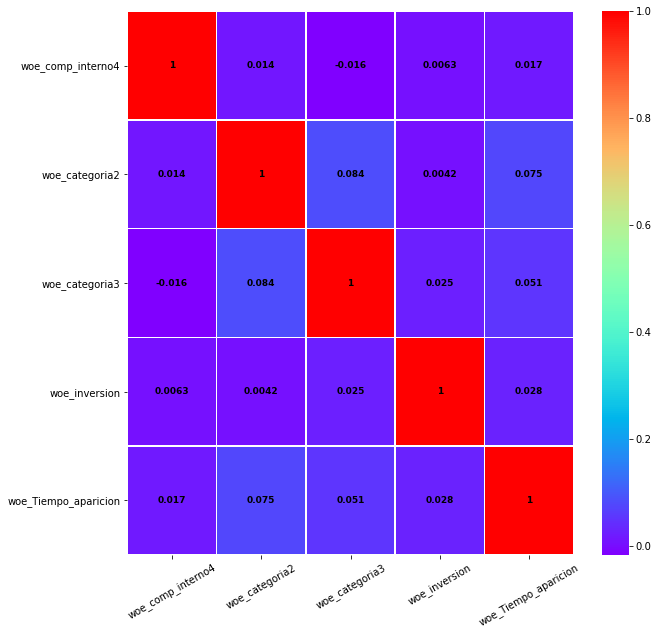

In [238]:
corr = X_woe_trainf.corr()


xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [239]:
y_train.head(20)

48824    1
2704     1
25631    1
7285     1
27346    1
40815    1
22137    1
25070    1
15687    1
14780    1
29571    1
42308    1
44083    1
27287    1
41101    1
10361    1
4824     1
36601    1
32958    1
44982    1
Name: credito, dtype: int64

In [240]:
model=LogisticRegression()
clf=model.fit(X_woe_trainf,y_train)

y_pred
 [1 1 1 ... 1 1 1]
y_pred1
 [3.97970285 2.59567213 2.34438583 ... 2.62239339 2.57590142 2.69374242]


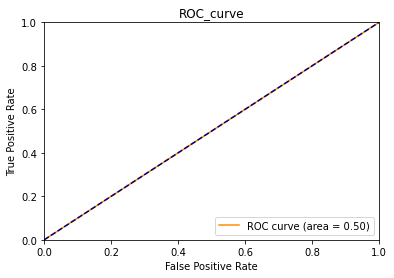

In [241]:
y_pred=clf.predict(X_woe_trainf)
y_pred1=clf.decision_function(X_woe_trainf)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_train, y_pred)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

In [242]:
coe=model.coef_
coe[0]

array([0.87812216, 1.04380565, 1.10102058, 0.80814327, 0.5244319 ])

In [243]:
premade="woe_"
for i in range(len(denuevo)):
    test[premade+denuevo[i]]=opts[i].transform(test[denuevo[i]], metric="woe")

In [244]:
#X_woe_test=test.iloc[:,21:]
#y_test=test.iloc[:,20]
X_woe_test=test.iloc[:,14:]
y_test=test.iloc[:,13]

In [232]:
#X_woe_testf= X_woe_test.drop(columns=["woe_comp_externo2","woe_comp_externo3","woe_comp_externo4","woe_comp_interno2","woe_comp_interno3","woe_comp_interno4","woe_categoria1","woe_avg(comportamiento_j)","woe_uno_o_mas","woe_max(comportamiento_j)"])
X_woe_testf= X_woe_test.drop(columns=["woe_comp_mixto1","woe_comp_interno1","woe_comp_interno2","woe_comp_interno3","woe_categoria1","woe_mean_comportamiento_j"])

y_pred
 [1 1 1 ... 1 1 1]
y_pred1
 [2.86315443 2.73663107 2.99474482 ... 2.91207579 2.69036932 2.50143443]


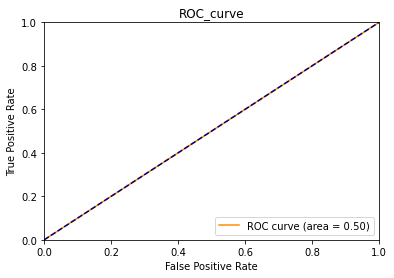

In [233]:
y_pred=clf.predict(X_woe_testf)
y_pred1=clf.decision_function(X_woe_testf)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

# ÁRBOL

In [112]:
X = base_general_4

In [113]:
y = X.pop('Respuesta')

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)